In [1]:
seed = 56
use_maf = False

# simulation setup
setup_opts = {        
    'n_hiddens': [50, 50],
    'reg_lambda': 0.01,
    'pilot_samples': 100,
    'verbose': True,
    'prior_norm': False,    
    'svi': False,
    'n_rnn': 0,
    'n_inputs_rnn': 2
}


run_opts = {
    'n_train': 1000,
    'n_rounds': 10,
    'minibatch': 100,
    'epochs': 100,
    'moo': 'resample',
    'proposal': 'discrete',
    'n_null': None,
    'train_on_all': True
}
  
if run_opts['train_on_all']:
    run_opts['epochs'] = [run_opts['epochs'] // (r+1) for r in range(run_opts['n_rounds'])]

if use_maf:
    # control MAF seed
    rng_maf = np.random
    rng_maf.seed(seed)
    
    setup_opts.update({
        'mode': 'random',
        'n_mades': 5,
        'rng': rng_maf,
        'act_fun': 'tanh',
        'batch_norm': False
    })

pars_true = np.array([-4.60517019, -0.69314718,  0.        , -4.60517019])  # from SNL paper

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import timeit
from copy import deepcopy

from delfi.utils.viz import plot_pdf
import delfi.inference as infer
import delfi.distribution as dd
import delfi.generator
from delfi.summarystats import Identity

from lfimodels.snl_exps.util import save_results, load_results, StubbornGenerator, stubborn_defaultrej
from lfimodels.snl_exps.util import init_g_lv as init_g
from lfimodels.snl_exps.util import load_setup_lv as load_setup
from lfimodels.snl_exps.util import load_gt_lv as load_gt
from lfimodels.snl_exps.util import calc_all_lprob_errs
from lfimodels.snl_exps.LotkaVolterra import LotkaVolterra, LotkaVolterraStats
import snl.simulators.lotka_volterra as sim_lv

model_id = 'lv'
save_path = 'results/' + model_id
exp_id = 'seed'+str(seed)

print('pars_true : ', pars_true)

/opt/anaconda3/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


pars_true :  [-4.60517019 -0.69314718  0.         -4.60517019]


Using cuDNN version 7401 on context None
Mapped name None to device cuda: GeForce RTX 2080 (0000:42:00.0)


In [3]:
model = LotkaVolterra(dt=0.2, duration=30.0)
prior = dd.Uniform(lower= [-5,-5,-5,-5], upper = [2,2,2,2])
summary = LotkaVolterraStats()
#Identity(idx = np.arange(10))
g = StubbornGenerator(model=model, prior=prior, summary=summary)


#x0 was generate by simulation using the parameters from the SNL papers, initial state removed
raw_data = np.array([ 59., 104.,  66., 117.,  81., 133.,  97., 131., 109., 135., 127.,
       132., 148., 135., 163., 125., 188., 108., 217.,  95., 239.,  75.,
       236.,  60., 235.,  46., 228.,  34., 217.,  28., 211.,  18., 193.,
        12., 175.,   8., 171.,   9., 162.,   5., 151.,   5., 136.,   6.,
       128.,   6., 111.,   8., 110.,   8.,  96.,   8.,  95.,   9.,  93.,
         9.,  81.,  10.,  80.,  11.,  78.,  17.,  74.,  17.,  72.,  19.,
        66.,  20.,  67.,  25.,  64.,  29.,  54.,  30.,  55.,  45.,  54.,
        45.,  53.,  48.,  48.,  50.,  54.,  65.,  61.,  75.,  64.,  77.,
        65.,  95.,  73., 106.,  85., 107.,  88., 114., 104., 113., 130.,
       114., 159., 110., 173.,  95., 196.,  77., 220.,  72., 219.,  49.,
       212.,  33., 209.,  24., 196.,  18., 188.,  18., 176.,  17., 166.,
        15., 158.,  14., 154.,  10., 138.,  13., 128.,  11., 119.,  11.,
       107.,   9.,  99.,   8.,  94.,  11.,  86.,  11.,  81.,  12.,  78.,
        15.,  67.,  19.,  63.,  16.,  58.,  20.,  58.,  28.,  57.,  36.,
        53.,  39.,  55.,  44.,  53.,  44.,  55.,  44.,  54.,  49.,  54.,
        66.,  54.,  77.,  53.,  93.,  64.,  98.,  76., 100.,  94., 110.,
       116., 112., 136., 102., 149., 105., 173., 103., 200.,  95., 208.,
        69., 224.,  54., 232.,  47., 217.,  40., 206.,  29., 202.,  24.,
       196.,  24., 181.,  23., 167.,  13., 158.,  14., 147.,   9., 135.,
         8., 121.,   9., 111.,   8.,  95.,  10.,  84.,  10.,  73.,  11.,
        68.,  14.,  61.,  16.,  57.,  20.,  50.,  19.,  46.,  25.,  43.,
        33.,  41.,  38.,  42.,  40.,  45.,  50.,  48.,  57.,  48.,  60.,
        47.,  63.,  49.,  68.,  48.,  66.,  42.,  71.,  43.,  84.,  46.,
        81.,  40.,  89.,  45., 121.,  55., 134.,  67., 136.,  83., 135.,
       100., 142., 129., 135., 148., 134., 163., 130., 182., 111., 195.,
       106., 206.,  93., 216.,  67., 224.,  47., 207.,  33., 202.,  24.,
       193.,  20., 182.,  14., 174.,   8., 161.,   8., 152.,   4., 140.,
         6., 131.,   5.])

x0 = summary.calc([dict(data=raw_data)])


In [4]:
# initialize inference object
res = infer.SNPEC(g, obs=x0, seed=seed, **setup_opts)

In [5]:
# train
t = timeit.time.time()
logs_C, tds_C, posteriors_C = res.run(**run_opts)
print('fitting time : ', timeit.time.time() - t)


combining data ...
n_train_round 1000



combining data ...
n_train_round 2000



combining data ...
n_train_round 3000



combining data ...
n_train_round 4000



combining data ...
n_train_round 5000



combining data ...
n_train_round 6000



combining data ...
n_train_round 7000



combining data ...
n_train_round 8000



combining data ...
n_train_round 9000



combining data ...
n_train_round 10000
fitting time :  1507.065458059311


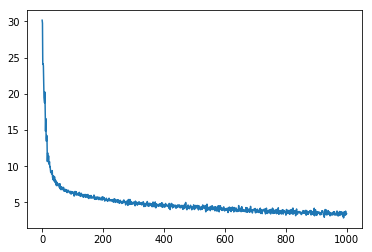

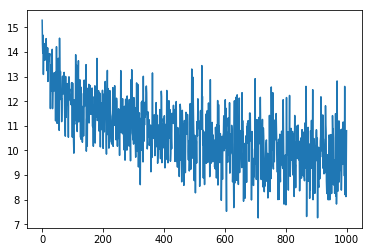

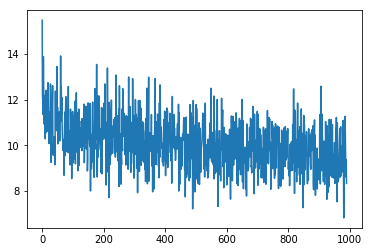

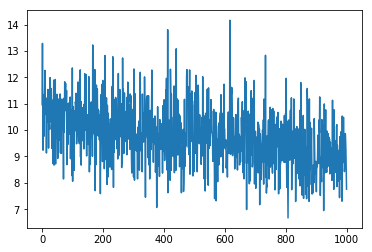

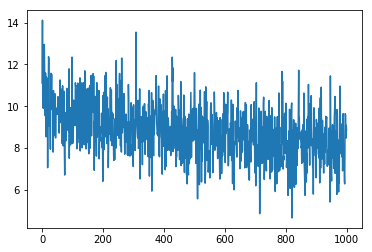

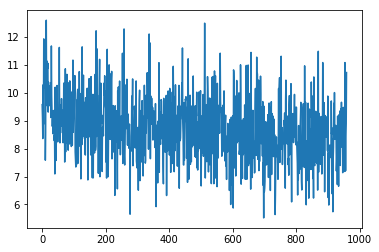

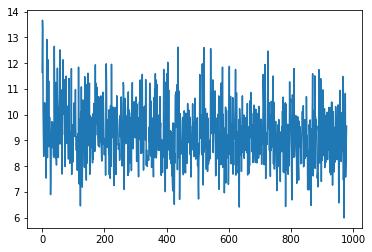

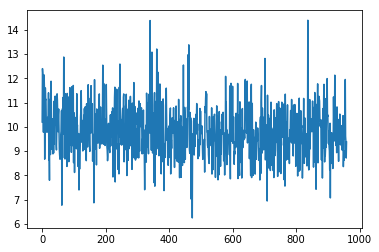

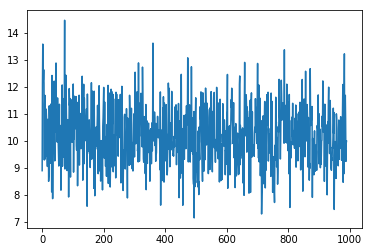

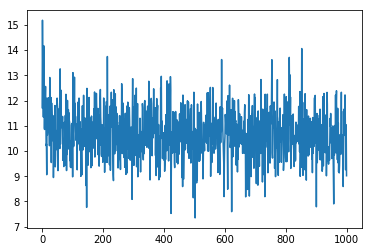

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,0,'round')

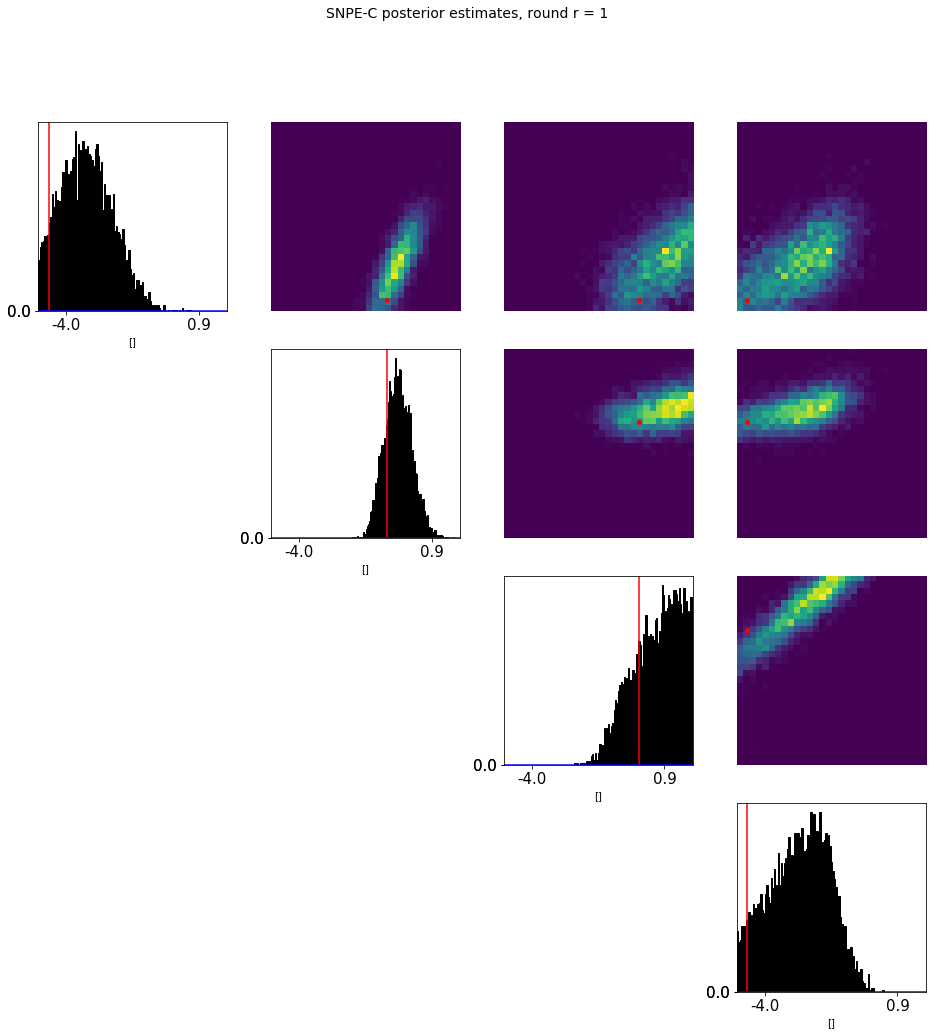

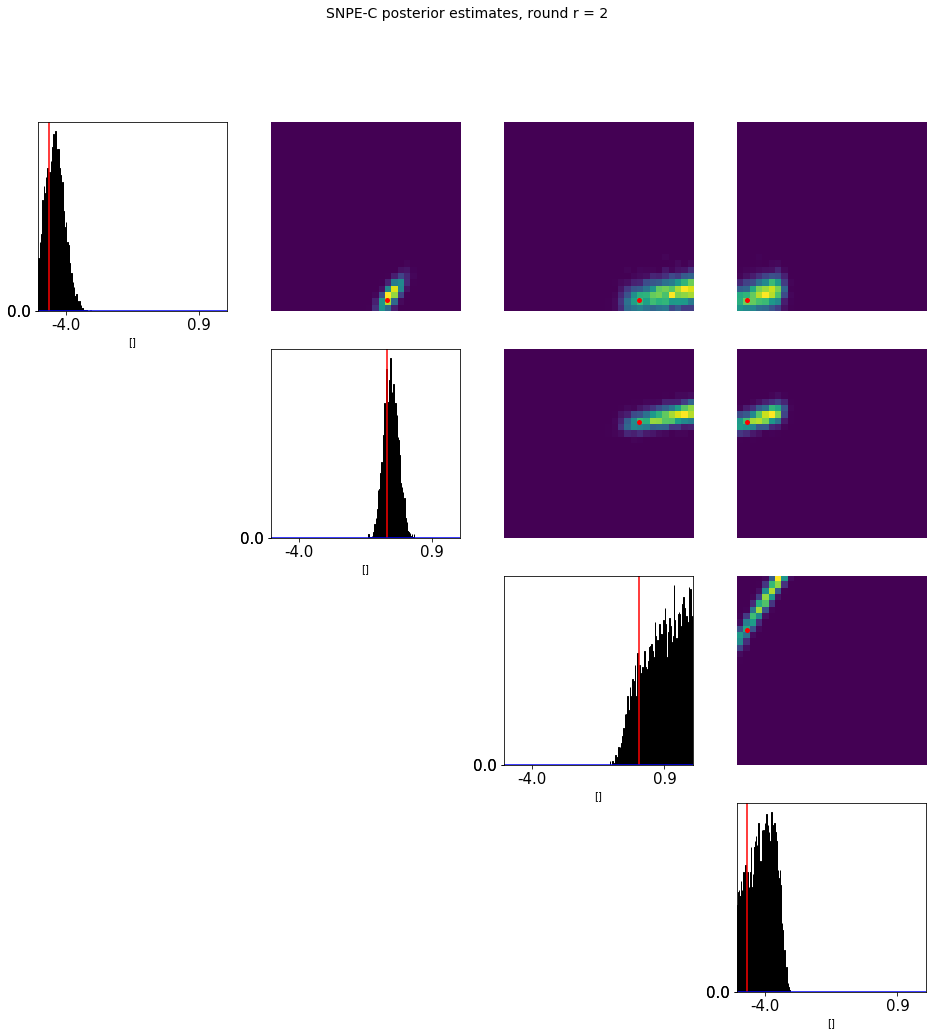

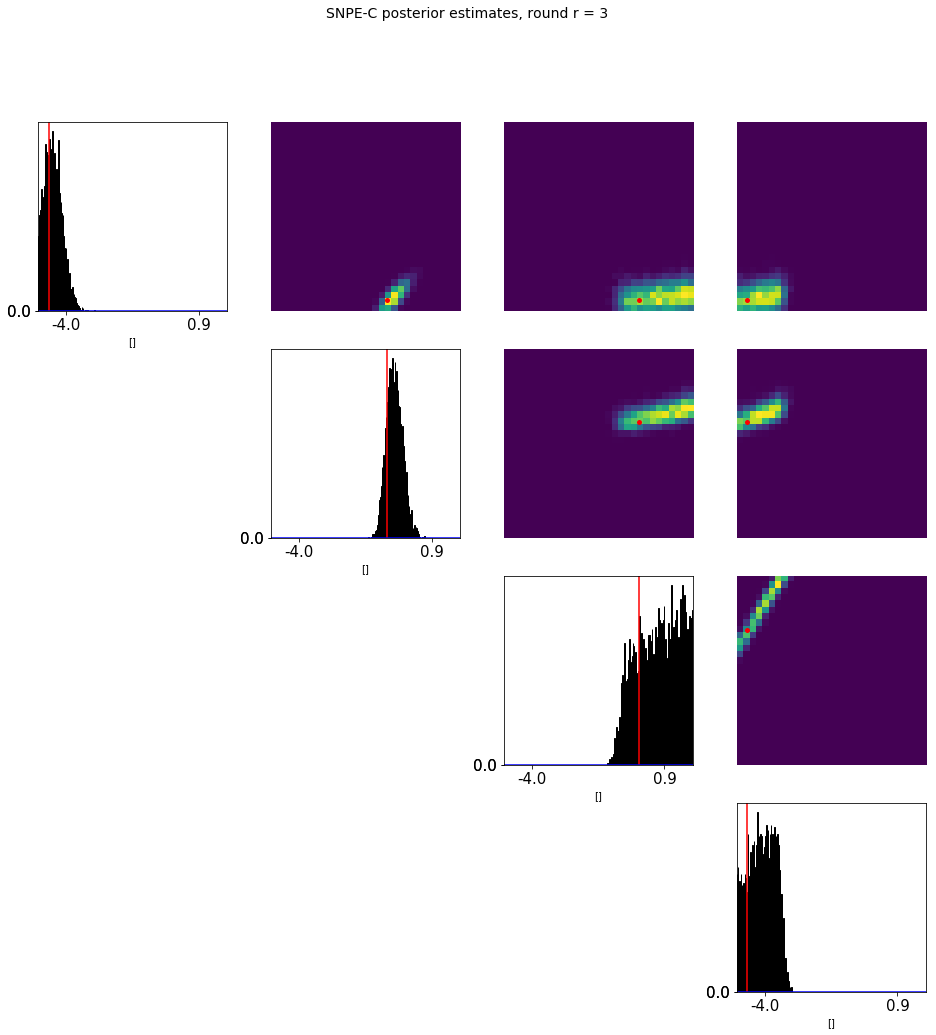

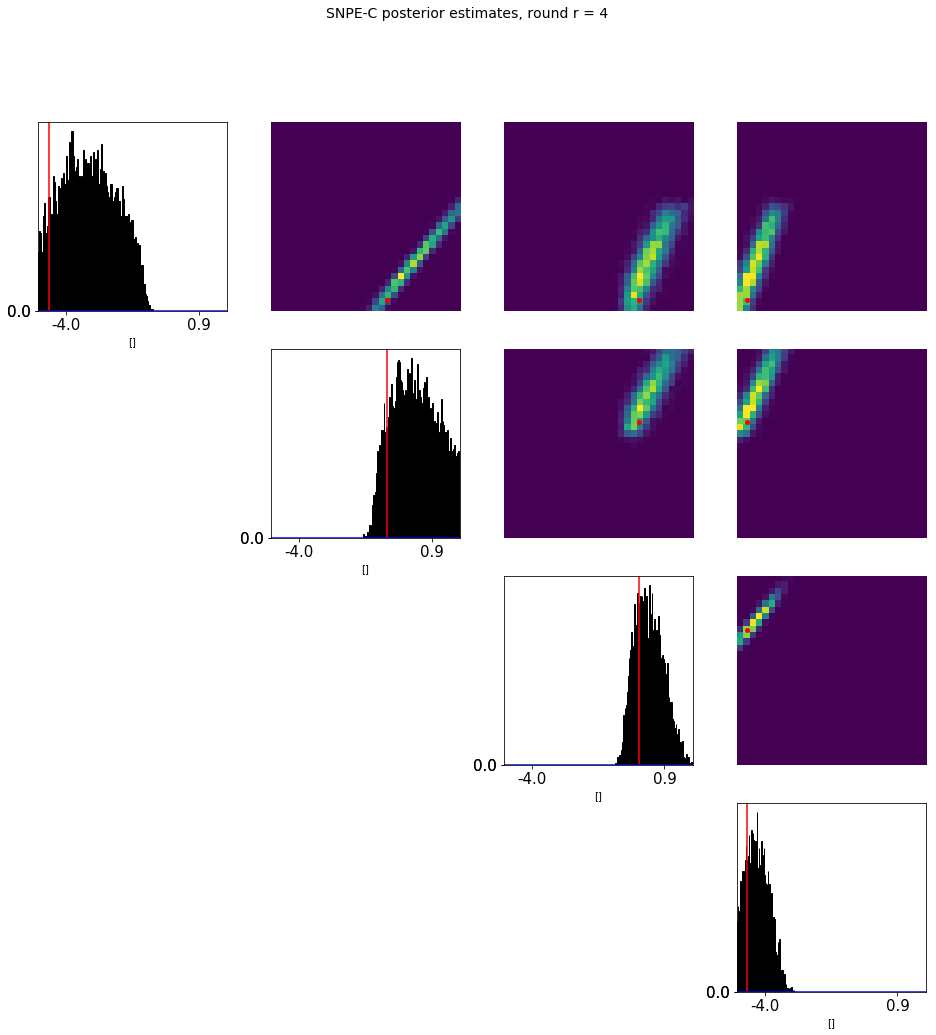

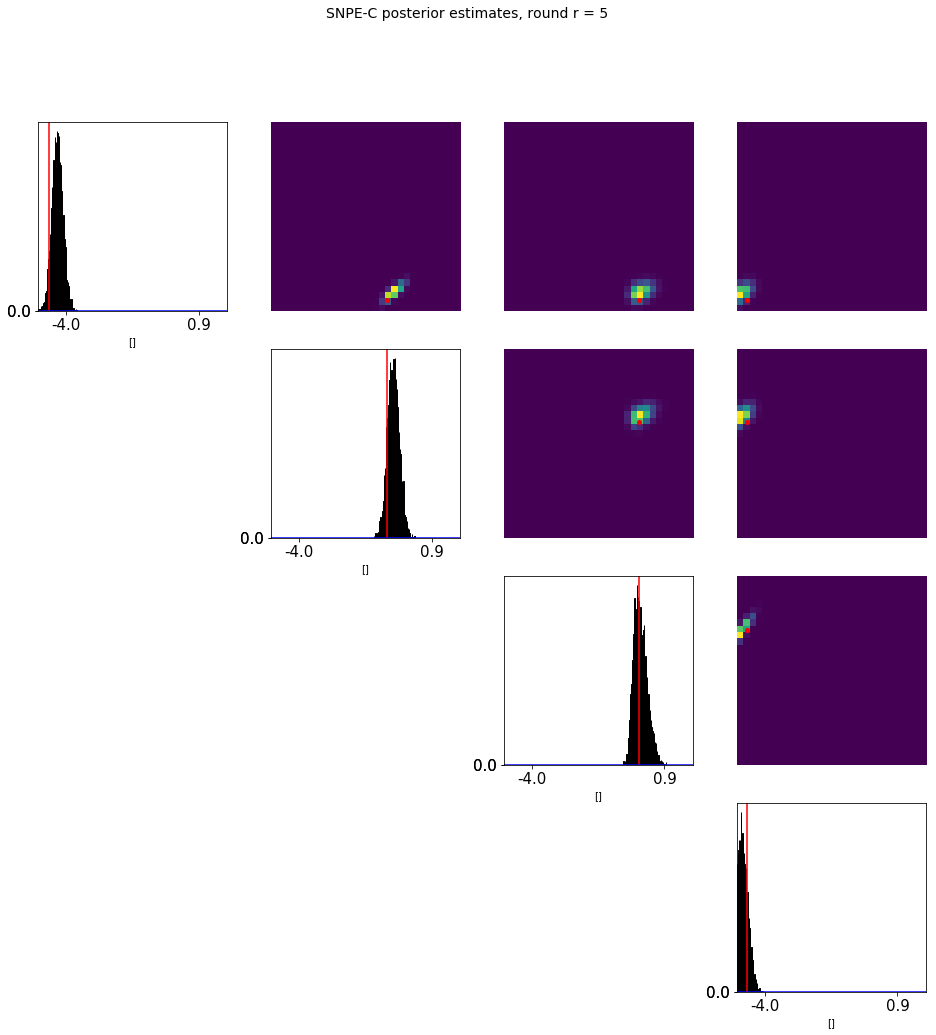

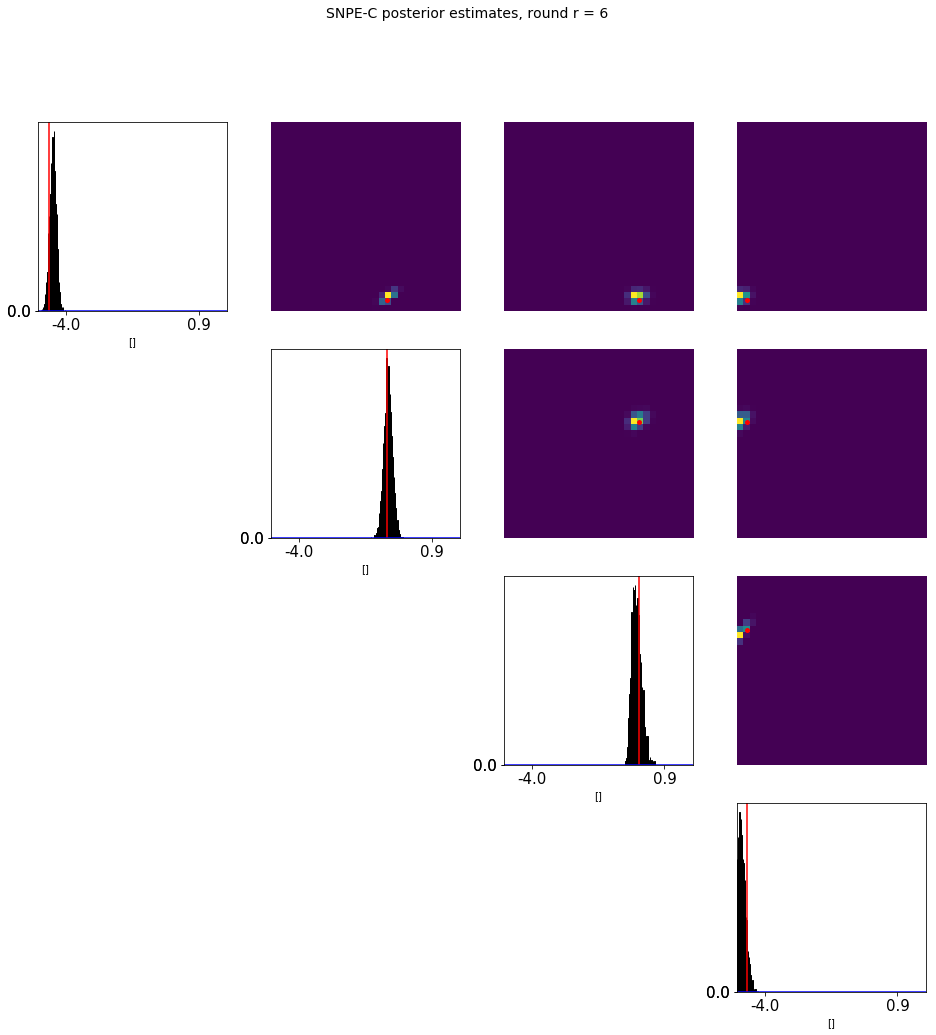

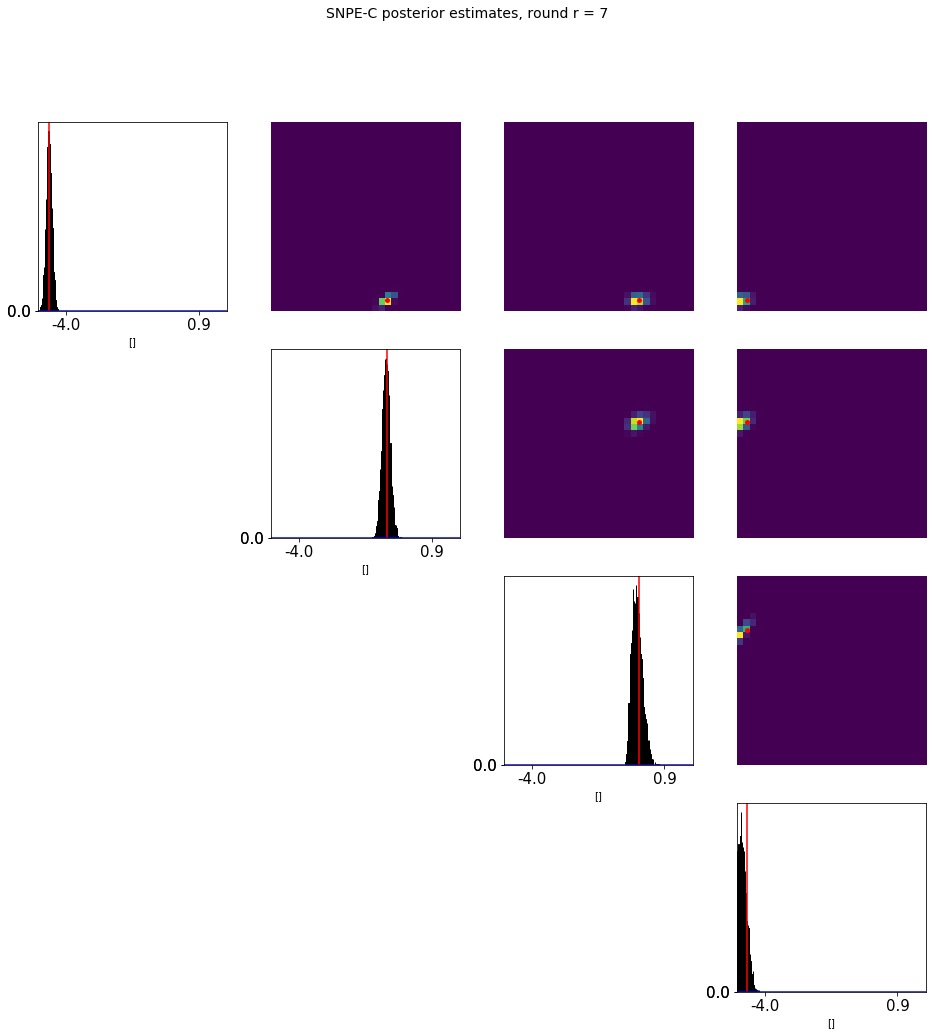

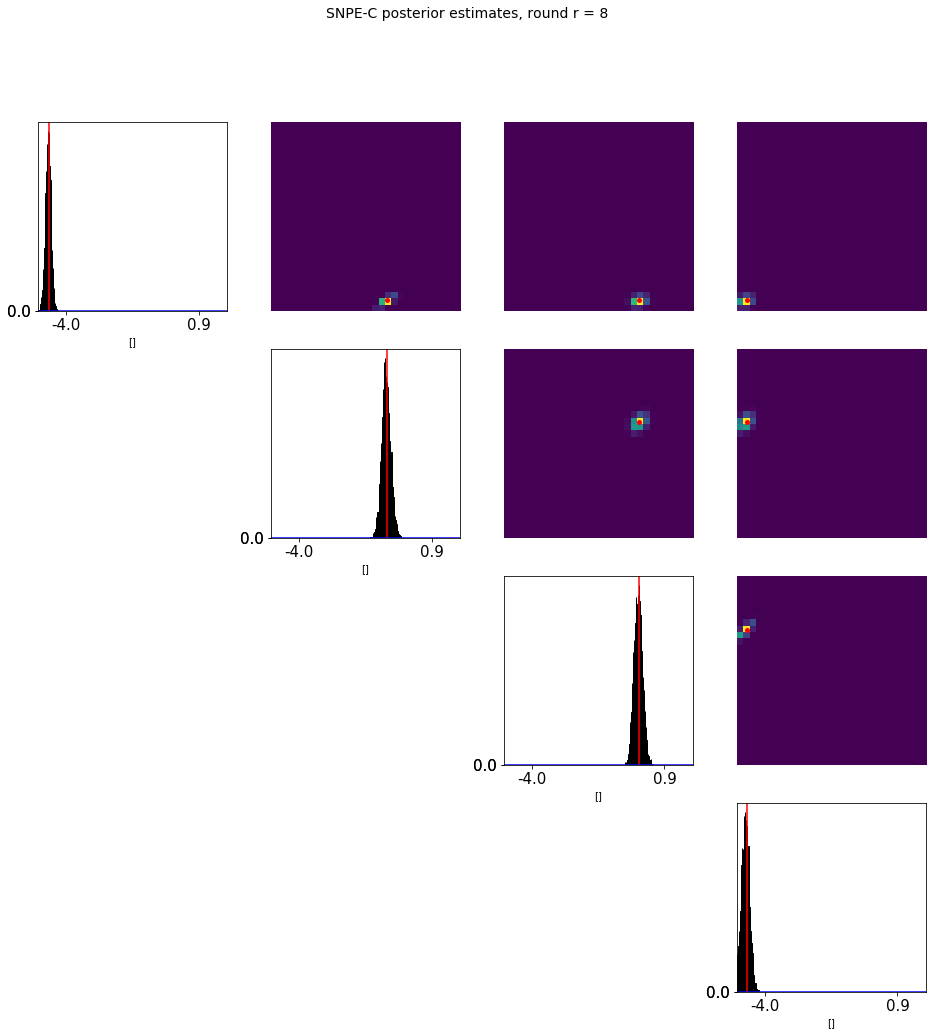

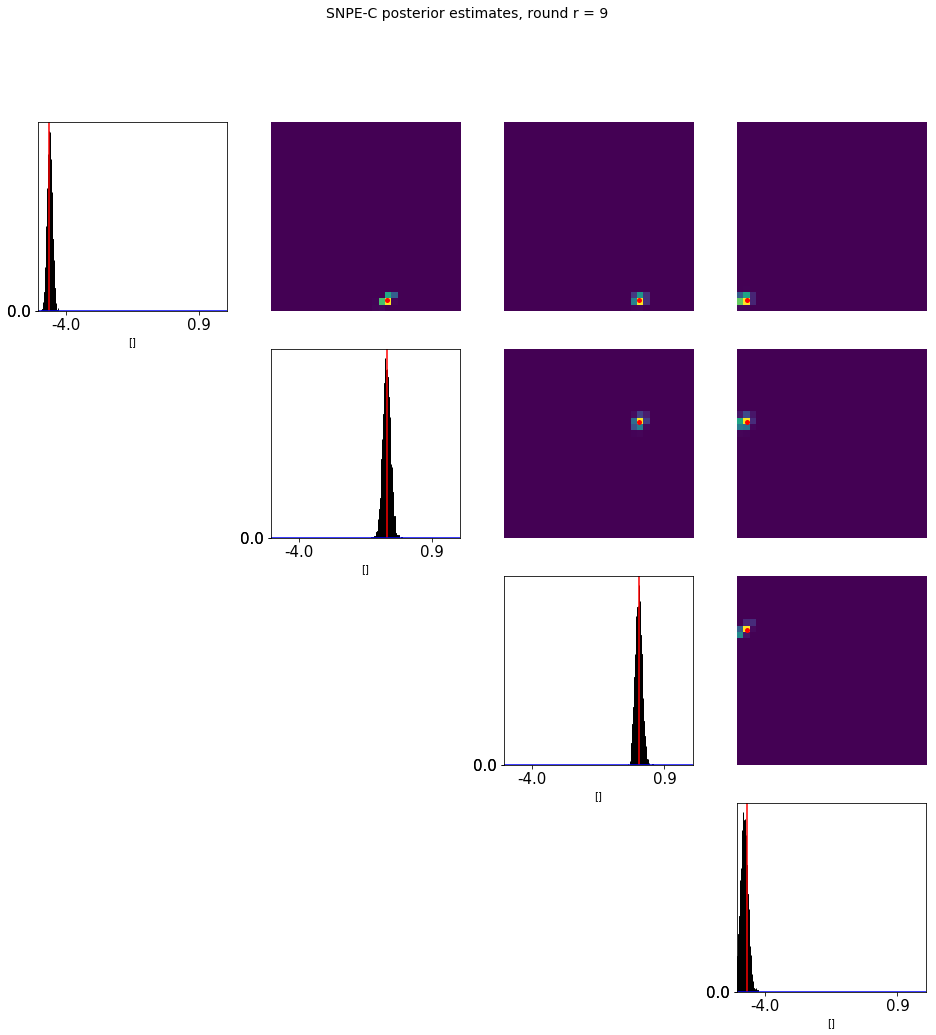

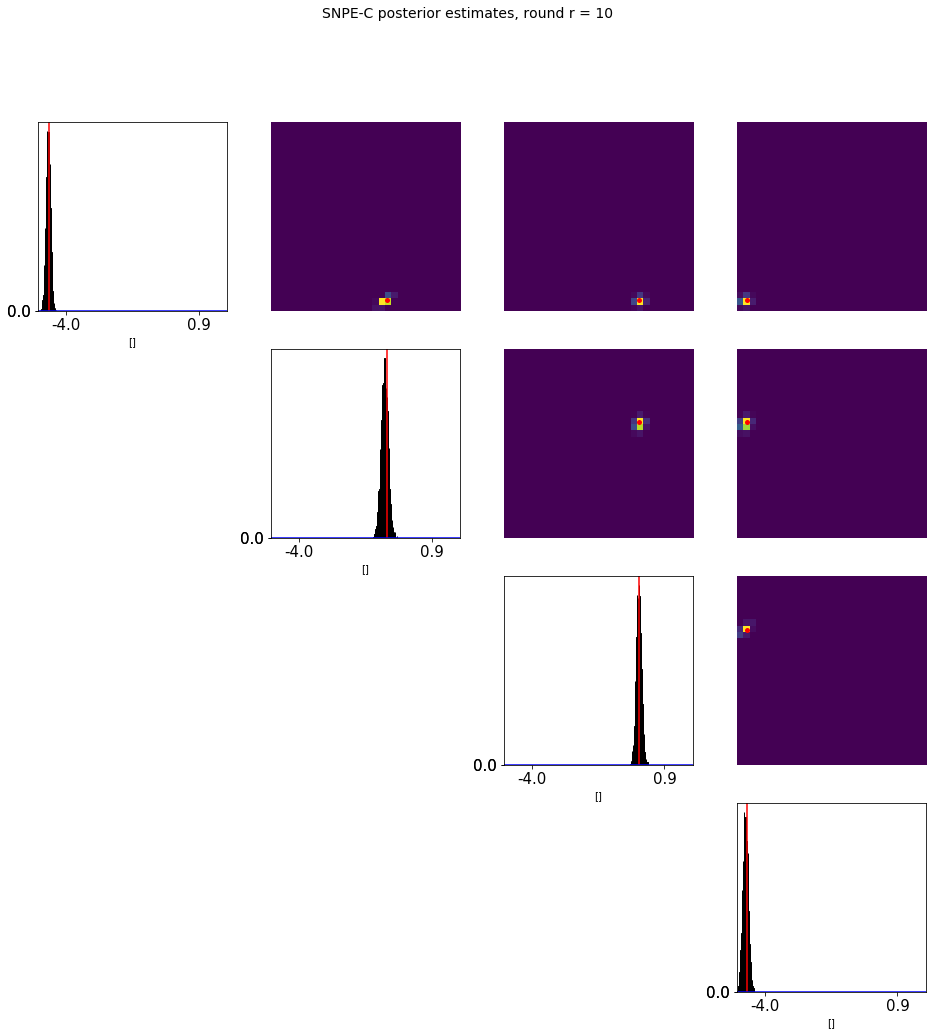

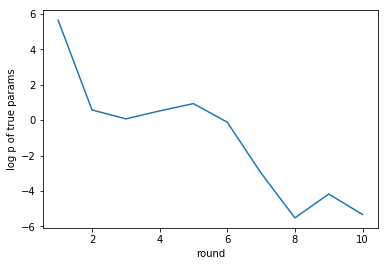

In [6]:
for r in range(run_opts['n_rounds']):
    plt.plot(logs_C[r]['loss'])
    plt.show()

for r in range(len(logs_C)):
    
    posterior_C = posteriors_C[r]
    #posterior_C.ndim = posterior_A.ndim
    
    g2 = deepcopy(g)
    g2.proposal = posterior_C
    samples = np.array(g2.draw_params(5000)) 
    
    fig,_ = plot_pdf(dd.Gaussian(m=0.00000123*np.ones(pars_true.size), S=1e-30*np.eye(pars_true.size)), 
                   samples=samples.T,
                   gt=pars_true, 
                   lims=[[-5,2],[-5,2],[-5,2],[-5,2]],
                   #lims=[0,10],
                   resolution=100,
                   ticks=True,
                   figsize=(16,16));
    
    fig.suptitle('SNPE-C posterior estimates, round r = '+str(r+1), fontsize=14)
        
plt.figure()
plt.plot(np.arange(run_opts['n_rounds']) + 1, [-posterior_C.eval(pars_true.reshape(1, -1), log=True) for posterior_C in posteriors_C])
plt.ylabel('-log p of true params')
plt.xlabel('round')

In [7]:
if False:
    d = model.gen(np.tile(pars_true, (100, 1)))
    y = np.stack([x[0]['data'] for x in d if x[0]['data'] is not None])
    a, b = y[:,::2].T, y[:,1::2].T
    plt.plot(a,'b'); plt.plot(b,'g');

In [ ]:
if False:
    d = model.gen(np.tile(pars_true, (100, 1)))
    y = np.stack([x[0]['data'] for x in d if x[0]['data'] is not None])
    a, b = y[:,::2].T, y[:,1::2].T
    plt.plot(a,'b'); plt.plot(b,'g');

In [13]:
posterior_C.xs[0].S

array([[0.00666153, 0.00900164, 0.00110761, 0.00132658],
       [0.00900164, 0.01573122, 0.00287965, 0.00330651],
       [0.00110761, 0.00287965, 0.00935669, 0.00827804],
       [0.00132658, 0.00330651, 0.00827804, 0.00986128]])